# HGG Gradients
This notebook demonstrates how to compute gradients/sensitivities with different methods, and provides a brief performance comparison of each method.

In [2]:
import os
import time
from datetime import timedelta
from enum import Enum
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from dotenv import load_dotenv
from pydantic import FilePath

from tumortwin.models import ReactionDiffusion3D
from tumortwin.postprocessing import compute_total_cell_count
from tumortwin.preprocessing import ADC_to_cellularity, compute_carrying_capacity
from tumortwin.solvers import TorchDiffEqSolver, TorchDiffEqSolverOptions
from tumortwin.types import (
    ChemotherapySpecification,
    CropSettings,
    CropTarget,
    HGGPatientData,
    RadiotherapySpecification,
)
from tumortwin.utils import daterange

### Load in HGG Patient data

In [3]:
try:
    patient_dir = os.environ.get("patient_dir")
    image_dir = os.environ.get("image_dir")
    assert patient_dir is not None
    assert image_dir is not None
    PATIENT_INFO_PATH = FilePath(patient_dir)
    IMAGE_PATH = Path(image_dir)
except:
    raise ValueError("Missing environment variables! Check .env file")

crop_settings = CropSettings(crop_to = CropTarget.ROI_ENHANCE, padding = 10, visit_index=-1)
patient_data = HGGPatientData.from_file(
    PATIENT_INFO_PATH, image_dir=IMAGE_PATH, crop_settings=crop_settings
)

In [4]:
measured_cellularity_maps = []
for visit in patient_data.visits:
    cellularity = ADC_to_cellularity(
        visit.adc_image, visit.roi_enhance_image, visit.roi_nonenhance_image
    )
    measured_cellularity_maps.append(cellularity)

rt = RadiotherapySpecification(
    alpha=0.05,
    alpha_beta_ratio=10,
    times=[r.time for r in patient_data.radiotherapy],
    doses=[r.dose for r in patient_data.radiotherapy],
)
ct_doses = [c.dose for c in patient_data.chemotherapy]
ct = ChemotherapySpecification(
    sensitivity=0.2,
    decay_rate=9.2420,
    times=[c.time for c in patient_data.chemotherapy],
    doses=[c.dose for c in patient_data.chemotherapy],
)

k = 0.05
d = 0.1

### Create a wrapper function that will evaluate some quantity of interest (in this case the total tumor cell count at the terminal simulation time), as well as sensitivities with respect to the proliferation rate, k,  and diffusion coefficient, d, using the requested GradientMethod

In [5]:
class GradientMethod(Enum):
    FINITE_DIFFERENCE = 1
    BACK_PROP = 2
    ADJOINT = 3


def evaluate_quantity_of_interest(k: float, d: float, method: GradientMethod):
    carrying_capacity = compute_carrying_capacity(patient_data.brainmask_image)
    u0 = torch.from_numpy(measured_cellularity_maps[0].array)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def eval_qoi(k, d) -> torch.Tensor:
        k = torch.tensor(
            k,
            requires_grad=not (method == GradientMethod.FINITE_DIFFERENCE),
            device=device,
        )
        d = torch.tensor(
            d,
            requires_grad=not (method == GradientMethod.FINITE_DIFFERENCE),
            device=device,
        )
        theta = torch.tensor(1.0, requires_grad=False, device=device)

        model = ReactionDiffusion3D(
            k=k,
            d=d,
            theta=theta,
            patient_data=patient_data,
            initial_time=patient_data.visits[0].time,
            chemotherapy_specifications=[ct],
            radiotherapy_specification=rt,
        )

        solver_options = TorchDiffEqSolverOptions(
            step_size=timedelta(days=0.5),
            use_adjoint=(method == GradientMethod.ADJOINT),
            device=device,
            method="rk4",
        )

        solver = TorchDiffEqSolver(model, solver_options)
        t_initial = patient_data.visits[0].time + timedelta(days=20.0)
        t_final = patient_data.visits[0].time + timedelta(days=32.0)
        dt = 0.5
        timepoints = daterange(t_initial, t_final, timedelta(days=dt))

        _, predicted_cellularity_maps = solver.solve(
            timepoints=timepoints, u_initial=u0
        )

        predicted_cell_counts = [
            compute_total_cell_count(N, carrying_capacity)
            for N in predicted_cellularity_maps
        ]
        return predicted_cell_counts[-1], model

    qoi, model = eval_qoi(k, d)

    if method == GradientMethod.FINITE_DIFFERENCE:
        delta = 1e-6
        qoi_delta_k, _ = eval_qoi(k + delta, d + delta)
        dq_dk = (qoi_delta_k - qoi) / delta
        del qoi_delta_k

        qoi_delta_d, _ = eval_qoi(k, d + delta)
        dq_dd = (qoi_delta_d - qoi) / delta
        del qoi_delta_d
    else:
        qoi.backward()
        dq_dk = model.k.grad
        dq_dd = model.d.grad

    return qoi, dq_dk, dq_dd

### Profiling

In [6]:
start = time.time()
qoi_fd, dq_dk_fd, dq_dd_fd = evaluate_quantity_of_interest(
    k, d, GradientMethod.FINITE_DIFFERENCE
)
end = time.time()
elapsed_fd = end - start

Forward Simulation: [1996-12-05 00:00:00 to 1996-12-17 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

Forward Simulation: [1996-12-05 00:00:00 to 1996-12-17 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

Forward Simulation: [1996-12-05 00:00:00 to 1996-12-17 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

In [7]:
start = time.time()
qoi_ad, dq_dk_ad, dq_dd_ad = evaluate_quantity_of_interest(
    k, d, GradientMethod.BACK_PROP
)
end = time.time()
elapsed_ad = end - start

Forward Simulation: [1996-12-05 00:00:00 to 1996-12-17 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

In [8]:
start = time.time()
qoi_adj, dq_dk_adj, dq_dd_adj = evaluate_quantity_of_interest(
    k, d, GradientMethod.ADJOINT
)
end = time.time()
elapsed_adj = end - start

Forward Simulation: [1996-12-05 00:00:00 to 1996-12-17 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

### Plot results

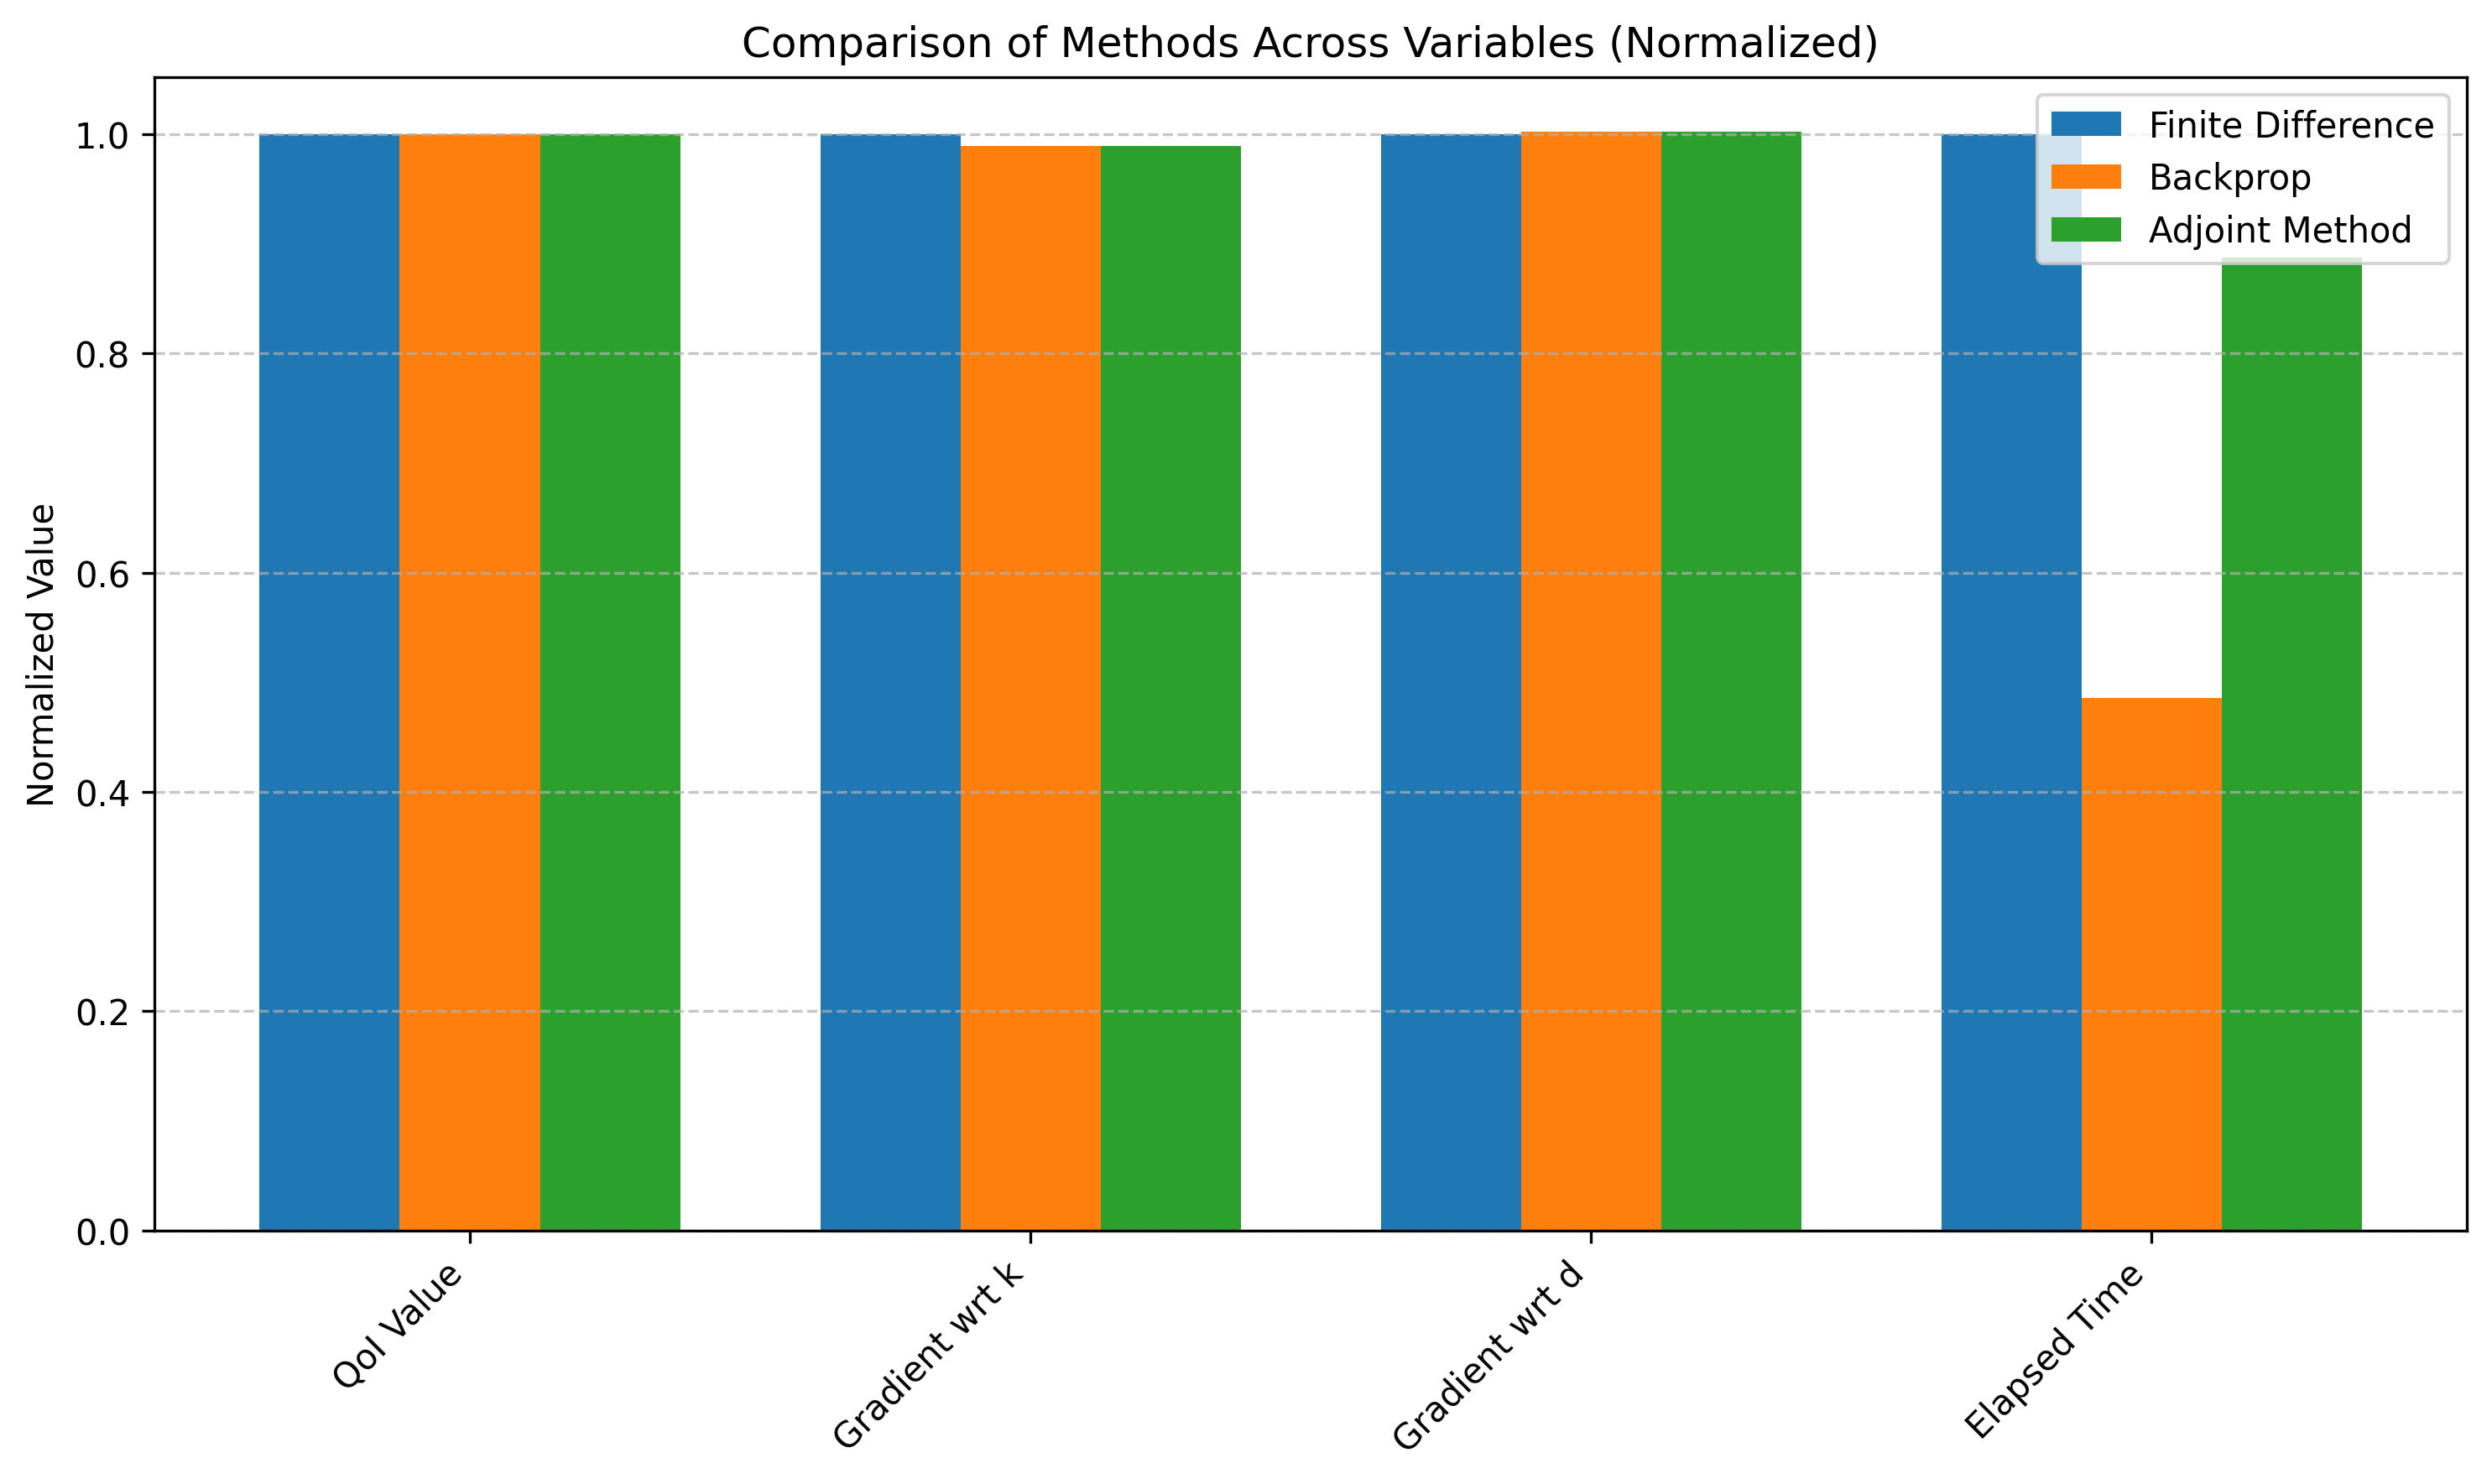

In [9]:
methods = ["Finite Difference", "Backprop", "Adjoint Method"]
variables = ["QoI Value", "Gradient wrt k", "Gradient wrt d", "Elapsed Time"]

# Raw data for each method and variable (rows: methods, columns: variables)
data = np.array(
    [
        [
            qoi_fd.detach(),
            dq_dk_fd.detach(),
            dq_dd_fd.detach(),
            elapsed_fd,
        ],  # Finite Difference (used as baseline for normalization)
        [qoi_ad.detach(), dq_dk_ad.detach(), dq_dd_ad.detach(), elapsed_ad],  # Backprop
        [
            qoi_adj.detach(),
            dq_dk_adj.detach(),
            dq_dd_adj.detach(),
            elapsed_adj,
        ],  # Adjoint Method
    ]
)

# Normalize data with respect to Finite Difference (row 0)
norm_data = data / data[0, :]

# Plotting
x = np.arange(len(variables))  # x positions for each variable
bar_width = 0.25  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each method
for i, method in enumerate(methods):
    ax.bar(x + i * bar_width, norm_data[i], width=bar_width, label=method)

# Add labels, title, and legend
ax.set_xticks(x + bar_width)
ax.set_xticklabels(variables, rotation=45, ha="right")
ax.set_ylabel("Normalized Value")
ax.set_title("Comparison of Methods Across Variables (Normalized)")
ax.legend()

# Show grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()